## Imports

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score, KFold, LeaveOneOut
from sklearn.linear_model import ElasticNet, Ridge, Lasso, Lars, LassoLars
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error


# another way of ignoring warnings
warnings.filterwarnings('ignore')

#### Loading dataset

In [274]:
Xtrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 2:]
ytrain = pd.read_csv("Xytrain_regression.csv").iloc[:, 1]

Xtest = pd.read_csv("Xytest_regression.csv").iloc[:, 2:]
ytest = pd.read_csv("Xytest_regression.csv").iloc[:, 1]

### Ridge Regression

Best parameters for Ridge:  {'alpha': 6.0606060606060606}
Best cross-validation score: 0.7360
R² Score on the test dataset: 0.7770
MSE on the test dataset: 1147.6921
RMSE on the test dataset: 33.8776


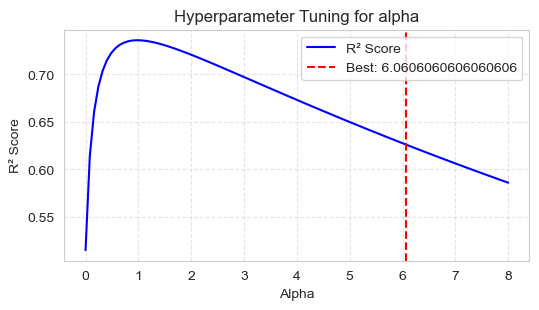

Best estimator: Ridge(alpha=6.0606060606060606)


In [291]:
# Initialize Ridge regression model
ridge = Ridge()

# Define the hyperparameter grid for alpha
param_grid_ridge = {
    'alpha' : np.linspace(0, 50, 100)
}

# Define KFold cross-validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#cv = LeaveOneOut()

# Use GridSearchCV with the KFold object
Ridge_ = GridSearchCV(ridge, param_grid_ridge, cv=cv, n_jobs=-1, return_train_score=True, scoring='r2')

# Fit the GridSearchCV
Ridge_.fit(Xtrain, ytrain)

# Print best parameters and best cross-validation score
print("Best parameters for Ridge: ", Ridge_.best_params_)
print("Best cross-validation score: {:.4f}".format(Ridge_.best_score_))

# Evaluate the best model on the test data
best_model_ridge = Ridge_.best_estimator_
y_pred_ridge = best_model_ridge.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_ridge)
test_MSE = mean_squared_error(ytest, y_pred_ridge)
test_RMSE = root_mean_squared_error(ytest, y_pred_ridge)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

# Get the mean test scores from the cross-validation results
alphas = np.linspace(0, 8, 100)
mean_test_scores = Ridge_.cv_results_['mean_test_score']

# Plot the results of hyperparameter tuning
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='R² Score')
plt.axvline(Ridge_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {Ridge_.best_params_['alpha']}")
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning for alpha')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {Ridge_.best_estimator_}')

In [292]:
# Get the mean test R² scores and standard deviations
meanError = list(Ridge_.cv_results_['mean_test_score'])
stdError = Ridge_.cv_results_['std_test_score']

# Find the index of the model with the highest mean R² score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

# Select the model with the highest alpha (if there are multiple models that satisfy the condition)
if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {Ridge_.cv_results_["param_alpha"][j]}')
print(f'One standard error rule gives the best model with mean_test_score (R²): {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 35.85858585858586
One standard error rule gives the best model with mean_test_score (R²): 0.6333414826271955 and std_test_score: 0.1494182500447228


In [293]:
alpha = Ridge_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
ridge = Ridge(alpha=alpha)
ridge.fit(Xtrain, ytrain)
y_pred_ridge = ridge.predict(Xtest)

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_ridge,
    'Squared Error (SE)': (ytest - y_pred_ridge) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_ridge)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

r2_ridge = r2_score(ytest, y_pred_ridge)
print(f'R² score for Ridge: {r2_ridge:.4f}')

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for Ridge: 0.7204
Mean Squared Error (MSE): 1439.48
Root Mean Squared Error (RMSE): 37.94
Standard Deviation of Actual Values: 73.61


### Lasso Regression

Best parameters for Lasso found:  {'alpha': 1.8181818181818181}
Best cross-validation score for Lasso: 0.8351
R² Score on the test dataset: 0.8365
MSE on the test dataset: 841.4585
RMSE on the test dataset: 29.0079


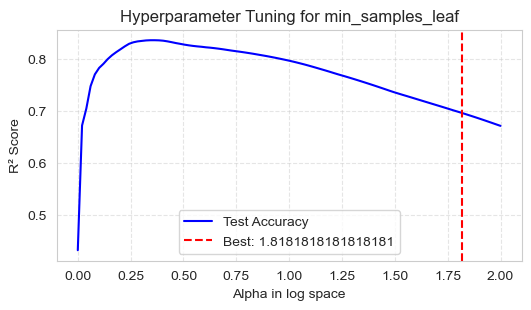

Best estimator: Lasso(alpha=1.8181818181818181)


In [294]:
# Initialize the Lasso model
lasso = Lasso()

# Define the hyperparameter grid for Lasso
param_grid_lasso = {
    'alpha': np.linspace(0, 10, 100)  # Fixed logspace range
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up the grid search with 5-fold cross-validation
Lasso_ = GridSearchCV(lasso, param_grid_lasso, cv=cv, scoring='r2')

# Fit the grid search to your training data
Lasso_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for Lasso found: ", Lasso_.best_params_)
print("Best cross-validation score for Lasso: {:.4f}".format(Lasso_.best_score_))

# Access the best model
best_model_lasso = Lasso_.best_estimator_

# Make predictions on the test set
y_pred_lasso = best_model_lasso.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_lasso)
test_MSE = mean_squared_error(ytest, y_pred_lasso)
test_RMSE = root_mean_squared_error(ytest, y_pred_lasso)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

alphas = np.linspace(0, 2, 100) 
mean_test_scores = Lasso_.cv_results_['mean_test_score']

# Plot results
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='Test Accuracy')
plt.axvline(Lasso_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {Lasso_.best_params_['alpha']}")
plt.xlabel('Alpha in log space')
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning for min_samples_leaf')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {Lasso_.best_estimator_}')

In [295]:
meanError = list(Lasso_.cv_results_['mean_test_score'])
stdError = Lasso_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We flip the sign of the std_error and compare
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
print(f'One standard error rule selects model with alpha: {Lasso_.cv_results_["param_alpha"][j]}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 6.565656565656566
One standard error rule gives the best model with mean_test_score: 0.7599660219805998 and std_test_score: 0.1068005749579389


In [296]:
alpha = Lasso_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
lasso = Lasso(alpha=alpha)
lasso.fit(Xtrain, ytrain)
y_pred_lasso = lasso.predict(Xtest)
r2_lasso = r2_score(ytest, y_pred_lasso)
print(f'R² score for Lasso: {r2_lasso:.4f}')

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_lasso,
    'Squared Error (SE)': (ytest - y_pred_lasso) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_lasso)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for Lasso: 0.7728
Mean Squared Error (MSE): 1169.34
Root Mean Squared Error (RMSE): 34.20
Standard Deviation of Actual Values: 73.61


### ElasticNEt REgression

In [297]:
# Initialize the ElasticNet model
elasticNet = ElasticNet()

# Define the hyperparameter grid for ElasticNet
param_grid_en = {
    'alpha': np.linspace(0, 10, 100) ,  # Alpha on a log scale from 0.001 to 1
    'l1_ratio': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1]
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Set up the grid search with 10-fold cross-validation
EN_ = GridSearchCV(elasticNet, param_grid_en, cv=cv, scoring='r2')

# Fit the grid search to your training data
EN_.fit(Xtrain, ytrain)

# Print the best parameters and score
print("Best parameters for ElasticNet found: ", EN_.best_params_)
print("Best cross-validation score for ElasticNet: {:.4f}".format(EN_.best_score_))

# Access the best model
best_model_en = EN_.best_estimator_

# Make predictions on the test set
y_pred_en = best_model_en.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_en)
test_MSE = mean_squared_error(ytest, y_pred_en)
test_RMSE = root_mean_squared_error(ytest, y_pred_en)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

# Extract the mean_test_score and reshape it to fit the grid of alphas and l1_ratios
mean_test_scores = EN_.cv_results_['mean_test_score'].reshape(len(param_grid_en['l1_ratio']), len(param_grid_en['alpha']))

Best parameters for ElasticNet found:  {'alpha': 1.8181818181818181, 'l1_ratio': 1}
Best cross-validation score for ElasticNet: 0.8351
R² Score on the test dataset: 0.8365
MSE on the test dataset: 841.4585
RMSE on the test dataset: 29.0079


In [298]:
# Retrieve the cross-validation results for ElasticNet
meanError = list(EN_.cv_results_['mean_test_score'])
stdError = EN_.cv_results_['std_test_score']

# Find the index of the model with the highest mean test score
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule to find acceptable models
# We check if any models' mean test score is within one standard error of the best model's score
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

if len(J) > 0:
    j = int(J[-1])  # Select the most regularized model (simpler model with a higher alpha)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one

# Print the hyperparameters of the selected model
selected_alpha = EN_.cv_results_['param_alpha'][j]
selected_l1_ratio = EN_.cv_results_['param_l1_ratio'][j]

print(f'One standard error rule selects model with alpha: {selected_alpha} and l1_ratio: {selected_l1_ratio}')
print(f'One standard error rule gives the best model with mean_test_score: {meanError[j]} and std_test_score: {stdError[j]}')

One standard error rule selects model with alpha: 6.565656565656566 and l1_ratio: 1.0
One standard error rule gives the best model with mean_test_score: 0.7599660219805998 and std_test_score: 0.1068005749579389


In [299]:
alpha = EN_.cv_results_["param_alpha"][j]

# Ridge Model (alpha=10)
en = ElasticNet(alpha=selected_alpha, l1_ratio=selected_l1_ratio)
en.fit(Xtrain, ytrain)
y_pred_en = en.predict(Xtest)
r2_en = r2_score(ytest, y_pred_en)
print(f'R² score for ElasticNet: {r2_en:.4f}')

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_en,
    'Squared Error (SE)': (ytest - y_pred_en) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_en)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for ElasticNet: 0.7728
Mean Squared Error (MSE): 1169.34
Root Mean Squared Error (RMSE): 34.20
Standard Deviation of Actual Values: 73.61


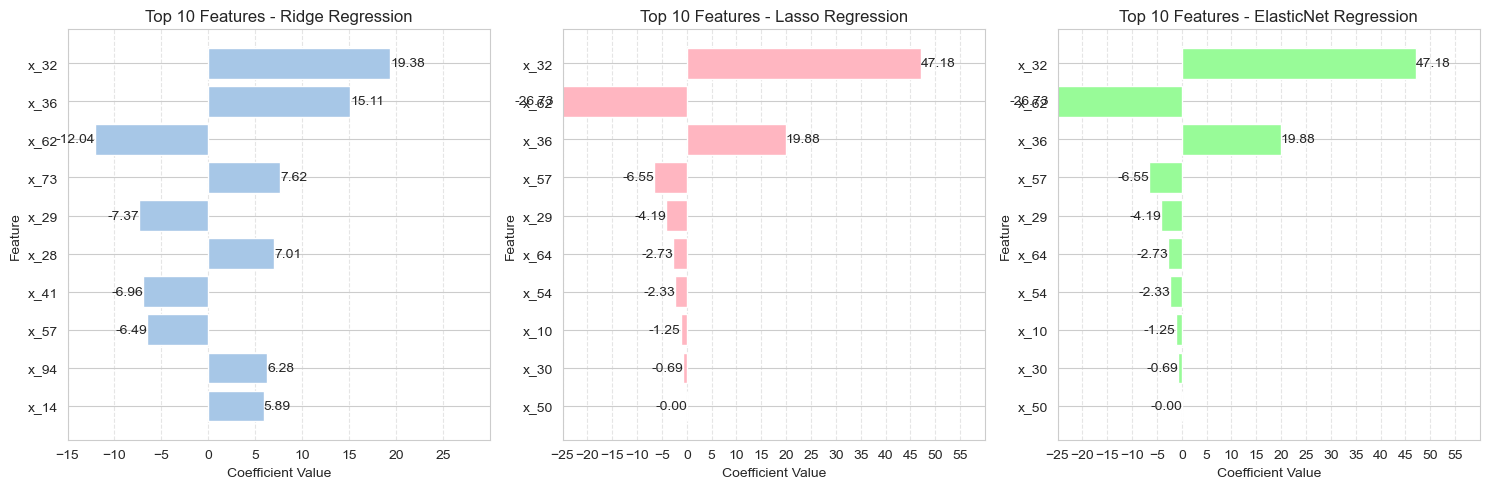

In [300]:
# Feature names (assuming Xtrain is a DataFrame, otherwise use indices)
feature_names = Xtrain.columns

def get_top_features(model):
    """Extract top 10 features based on absolute weight values."""
    coef = model.coef_
    abs_coef = np.abs(coef)
    
    # Get indices of top 10 features
    top_indices = np.argsort(abs_coef)[-10:]  # Top 10 by absolute magnitude
    
    # Get feature names and corresponding values
    top_features = [feature_names[i] for i in top_indices]
    top_values = coef[top_indices]
    
    return top_features, top_values

# Get top features for each model
ridge_features, ridge_values = get_top_features(ridge)
lasso_features, lasso_values = get_top_features(lasso)
en_features, en_values = get_top_features(en)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Use Seaborn style for pastel aesthetics
sns.set_style("whitegrid")

# Define pastel colors
colors = ["#A7C7E7", "#FFB6C1", "#98FB98"]  # Pastel Blue, Pastel Pink, Pastel Green

# Function to plot bars with values on top
def plot_feature_importance(ax, features, values, title, color, xlim_range):
    ax.barh(features, values, color=color)
    ax.set_title(title)
    ax.set_xlabel("Coefficient Value")
    ax.set_ylabel("Feature")
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.set_xlim(xlim_range[0], xlim_range[1])
    ax.set_xticks(np.arange(xlim_range[0], xlim_range[1], 5))

    # Add value labels
    for i, v in enumerate(values):
        ax.text(v, i, f"{v:.2f}", va='center', ha="left" if v > 0 else "right", fontsize=10)

# Plot Ridge
plot_feature_importance(axes[0], ridge_features, ridge_values, "Top 10 Features - Ridge Regression", colors[0], (-15, 30))

# Plot Lasso
plot_feature_importance(axes[1], lasso_features, lasso_values, "Top 10 Features - Lasso Regression", colors[1], (-25, 60))

# Plot ElasticNet
plot_feature_importance(axes[2], en_features, en_values, "Top 10 Features - ElasticNet Regression", colors[2], (-25, 60))

# Adjust layout
plt.tight_layout()
plt.show()

#### Least angle regression and selection (LARS)

The Least Angle Regression (LARS) method The Lasso strategy in linear regression combines the regularization capabilities of L1 regularization (also called Lasso) with the efficiency of forward selection. Loss of arousal As it moves in the direction of the target variable's greatest correlation, Lasso gradually adds features to the model. This process is continued until a point is reached at which the correlation between the additional variable and the original one would be equal. Due to its tendency to choose a sparse subset of characteristics, this approach works especially well with high-dimensional data. Models with fewer non-zero coefficients are encouraged to be sparse by the regularization term (L1 penalty).

Positive LAsso: Better Stability: Helps avoid issues when highly correlated features lead to coefficients flipping signs.

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best n_nonzero_coefs: 1.8181818181818181
Best Cross-Validation R² score: 0.8351
R² Score on the test dataset: 0.8364
MSE on the test dataset: 841.9488
RMSE on the test dataset: 29.0164


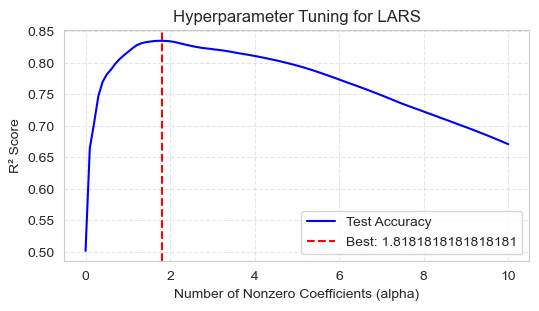

Best estimator: LassoLars(alpha=1.8181818181818181)


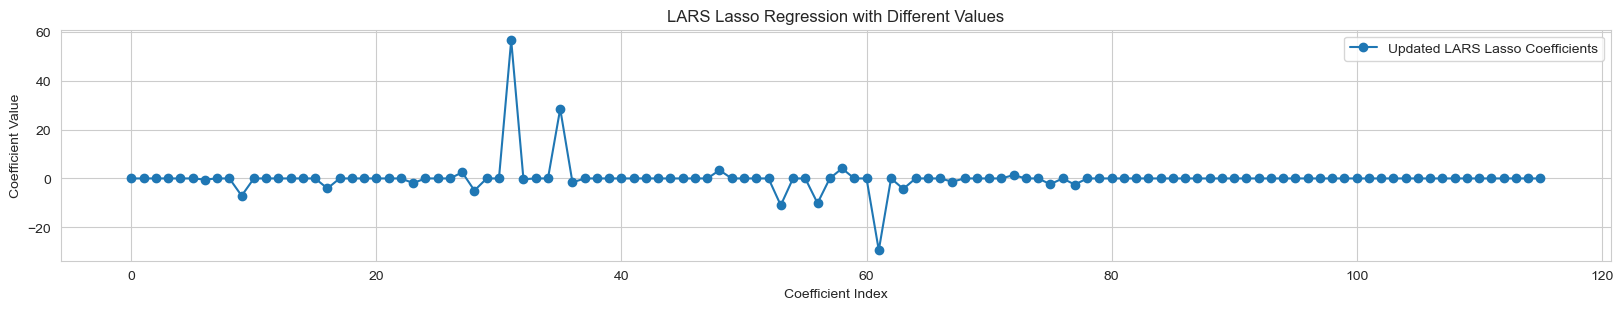

In [302]:
# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid = {
    "alpha": np.linspace(0, 10, 100)
} 

# Define Lars model
lassolars = LassoLars()

# Use GridSearchCV
LAssoLars_ = GridSearchCV(lassolars, param_grid, scoring="r2", cv=kf, n_jobs=-1, verbose=1)
LAssoLars_.fit(Xtrain, ytrain)

# Get best parameters & results
best_n = LAssoLars_.best_params_["alpha"]
best_mse = LAssoLars_.best_score_

print(f"Best n_nonzero_coefs: {best_n}")
print(f"Best Cross-Validation R² score: {best_mse:.4f}")

# Access the best model
best_model_lars = LAssoLars_.best_estimator_

# Make predictions on the test set
y_pred_lars = best_model_lars.predict(Xtest)

# Calculate R² score on test set
test_R2 = r2_score(ytest, y_pred_lars)
test_MSE = mean_squared_error(ytest, y_pred_lars)
test_RMSE = root_mean_squared_error(ytest, y_pred_lars)

print("R² Score on the test dataset: {:.4f}".format(test_R2))
print("MSE on the test dataset: {:.4f}".format(test_MSE))
print("RMSE on the test dataset: {:.4f}".format(test_RMSE))

alphas = np.linspace(0, 10, 100)
mean_test_scores = LAssoLars_.cv_results_['mean_test_score']

# Plot results
plt.figure(figsize=(6, 3))
plt.plot(alphas, mean_test_scores, linestyle='-', color='b', label='Test Accuracy')
plt.axvline(LAssoLars_.best_params_['alpha'], color='r', linestyle='--', label=f"Best: {LAssoLars_.best_params_['alpha']}")
plt.xlabel('Number of Nonzero Coefficients (alpha)')
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning for LARS')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Print best estimator
print(f'Best estimator: {LAssoLars_.best_estimator_}')

plt.figure(figsize=(20, 3))
plt.plot(best_model_lars.coef_, marker='o', label='Updated LARS Lasso Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.legend()
plt.title('LARS Lasso Regression with Different Values')
plt.show()

In [303]:
# Retrieve cross-validation results for LARS
meanError = list(LAssoLars_.cv_results_['mean_test_score'])  # Mean R² scores
stdError = LAssoLars_.cv_results_['std_test_score']  # Standard deviation of R² scores

# Find the index of the best-performing model (highest mean test score)
maxAcc = meanError.index(max(meanError))

# Apply the One Standard Error Rule
J = np.where(meanError[maxAcc] - stdError[maxAcc] < meanError)[0]

# Select the most regularized model within the one standard error range
if len(J) > 0:
    j = int(J[-1])  # Choose the most regularized model (simpler with fewer nonzero coefficients)
else:
    j = maxAcc  # If no model satisfies the rule, keep the best one
    
# Print results
print(f'One Standard Error Rule selects model with alpha: {LAssoLars_.cv_results_["param_alpha"][j]}')
print(f'Mean R² Score: {meanError[j]:.4f}, Std Error: {stdError[j]:.4f}')

One Standard Error Rule selects model with alpha: 6.565656565656566
Mean R² Score: 0.7600, Std Error: 0.1068


In [306]:
param_alpha = LAssoLars_.cv_results_["param_alpha"][j]

# LAssoLars Model
lassolars = LassoLars(alpha = param_alpha)
lassolars.fit(Xtrain, ytrain)
y_pred_lassolars = lassolars.predict(Xtest)
r2_lassolars = r2_score(ytest, y_pred_lassolars)
print(f'R² score for ElasticNet: {r2_en:.4f}')

df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_lassolars,
    'Squared Error (SE)': (ytest - y_pred_lassolars) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_lassolars)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

R² score for ElasticNet: 0.7728
Mean Squared Error (MSE): 1169.35
Root Mean Squared Error (RMSE): 34.20
Standard Deviation of Actual Values: 73.61


In [307]:
# Get non-zero coefficients and corresponding feature indices
non_zero_indices = lassolars.coef_ != 0
non_zero_features = Xtrain.columns[non_zero_indices]  # Feature names (if using Pandas)
non_zero_coefs = lassolars.coef_[non_zero_indices]  # Corresponding coefficients

# Print results
print("Selected Features and Coefficients:")
for feature, coef in zip(non_zero_features, non_zero_coefs):
    print(f"{feature}: {coef:.4f}")

Selected Features and Coefficients:
x_10: -1.2476
x_29: -4.1957
x_30: -0.6867
x_32: 47.1796
x_36: 19.8828
x_54: -2.3328
x_57: -6.5476
x_62: -26.7277
x_64: -2.7314


In [308]:
df_compare = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred_lassolars,
    'Squared Error (SE)': (ytest - y_pred_lassolars) ** 2,  # Squared error
    'Absolute Error (AE)': np.abs(ytest - y_pred_lassolars)  # Absolute error
})

mse = df_compare["Squared Error (SE)"].mean()
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

std_actual = df_compare["Actual"].std()
print(f"Standard Deviation of Actual Values: {std_actual:.2f}\n")

#If RMSE < std_actual: The model is reasonably good.
#If RMSE ≈ std_actual: The model is performing just like a simple average prediction.
#If RMSE > std_actual: The model is performing poorly

print(df_compare)

Mean Squared Error (MSE): 1169.35
Root Mean Squared Error (RMSE): 34.20
Standard Deviation of Actual Values: 73.61

        Actual  Predicted  Squared Error (SE)  Absolute Error (AE)
0    74.689125  59.864256          219.776764            14.824870
1   110.649150  56.508234         2931.238777            54.140916
2    54.062438  56.271933            4.881868             2.209495
3    -5.811144  17.918100          563.076983            23.729243
4  -127.836283 -66.793030         3726.278685            61.043253
5   -34.997160 -33.610341            1.923267             1.386819
6     5.436023 -14.355542          391.706081            19.791566
7   -80.081820 -57.010273          532.296278            23.071547
8   -12.344749 -23.342060          120.940855            10.997311
9    63.214673  42.310349          436.990792            20.904325
10  -55.422649  10.114906         4295.171141            65.537555
11  -54.444574 -42.787114          135.896361            11.657459
12  101.77346